# BackBlaze Hard Drive Dataset

---
---

## About

---

This project practices Supervised Machine Learning using the [dataset](https://www.backblaze.com/b2/hard-drive-test-data.html) from BackBlaze. The goal is to predict hard drive failure.

Cloud-server companies has thousands of hard-drives running at all times.  If a hard-drive fails, they will have to be replaced and could result in lengthy downtimes.  If we could predict when a hard-drive will fail and pre-emptively replace the hard-drive before it does, we could increase the company's reliability and avoid costly malfunctions.

Every hard-drive has the ability to send daily reports about their status and can be tracked day-by-day.  Factors being tracked include the average temperature, nitrogen/oxygen level, quantity of read/writes, write errors, total run-time, etc.  With BackBlaze keeping records from 2013, we have ample data to try reading signs of hard-drive failure and understand what factors have the most weight in determining hard-drive failure.

## Limitations

---

Here are the limitations of this project that I am aware of:
#### Dataset size
Although the dataset is quite large (9 million, the limit of my computer's 32GB of RAM), after filtering by hard drive model, filtering by last-day recorded, splitting training and test set, and the huge class imbalance (~180:1), it left us with a tiny amount of failed hard-drives per set. I would expect to get more consistent results if we concact multiple quarters/years of data together.
#### Try other class-imbalance techniques
There are a lot of other class-imbalance techniques, such as under-fitting or combination of under/over-fitting and perhaps in the future we can compare results.
#### Try predicting even earlier
In this project, we only try predicting if a hard-drive will fail today.  Ideally we would like to know ahead of time, so in future projects, we would bag data and try experimenting to see what leads to best results, either the day before, week before, or even a month before.
#### Optimizing models
After picking the most promising models, I could spend more time optimizing the model.
#### Try other hard-drive models
We only looked at one particular hard-drive model.  In future projects it would make sense to go through these steps with other models to see if we get different results.

## Data Import

---

The files for a quarter-year in question were roughly 0.5GB compressed, I wanted to minimize the amount of space data occupied, so keeping them compressed/zipped was ideal.

The files are hosted on BackBlazes own servers, so I created a function that downloads the zip files if they weren't found on my local hard drive, extracts the files of interest (the daily .csv records) then concat them together into one big dataframe so we can explore them.

All the work can be seen on my `22.2a_SL_HardDriveData.ipynb` notebook.

## Data Exploration

---

Since 2013, BackBlaze has published statistics and insights based on the hard drives in their data center. The data consists of daily snapshots of each operational hard drive. This snapshot includes basic drive information along with the [S.M.A.R.T](https://en.wikipedia.org/wiki/S.M.A.R.T.) statistics reported by that drive. The daily snapshot of one drive is one row of data. All of the drive snapshots for a given day are collected into a csv file in the format YYYY-MM-DD.csv (e.g. 2013-04-10.csv) consisting of a row for each active hard drive.

The first row of each file contains the column names:

- **Date**
- **Serial Number** : Manufacturer assigned serial number of the drive
- **Model** : Manufacturer model of the drive
- **Capacity** : Drive capacity in bytes
- **Failure** : Binary label with 1 indicating that this was the last day the drive was operational before failing.
- **SMART stats**
    - 2013-2014 : Raw and Normalized values for 40 different SMART stats.
    - 2015-2017 : Raw and Normalized values for 45 different SMART stats.
    - 2018 (Q1) : Raw and Normalized values for 50 different SMART stats.
    - 2018 (Q2) : Raw and Normalized values for 52 different SMART stats.
    - 2018 (Q4) : Raw and Normalized values for 62 different SMART stats.


In [35]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Inbalance
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

# Train/Test Set
from sklearn.model_selection import train_test_split

# Pre-processing
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Cross Value Score
from sklearn.model_selection import cross_val_score

# Models
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Already imported, explored, wrangled, removed unnecessary columns, etc.
# in notebook 22.2a_SL_HardDriveData.ipynb

df = pd.read_csv('1st_quarter_ldw_df.csv')
df.shape

(32091, 22)

In [3]:
df.head(2)

,serial_number,date,model,capacity_bytes,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,smart_197_raw,smart_199_raw,smart_241_raw,smart_242_raw
0,S3000A9T,2018-03-31,ST4000DM000,4000787030016,0,120086104,35,0,246031129,7953,...,0,0,0,0,24,64184,0,0,11370796797,21233320572
1,S3000FZ5,2018-03-31,ST4000DM000,4000787030016,0,131527784,11,0,133315703,28231,...,0,0,0,0,25,9229,0,0,19527158150,86466728356


In [4]:
cols_to_keep = [col for col in df.columns if 'smart' in col]

features = df[cols_to_keep]
labels = df['failure']

## Managing Imbalance

There are a many ways of over-sampling the data.  I originally tried SMOTE, but tried using ADASYN in this notebook.  Differences in techniques should be explored in future projects, but for now, SMOTE is commented out.

In [5]:
X_train_raw, X_test, y_train_raw, y_test = train_test_split(features,
                                                            labels,
                                                            test_size=0.2,
                                                            random_state=123, 
                                                            stratify=labels)

#### SMOTE

In [6]:
# X_train, y_train = SMOTE().fit_resample(X_train_raw, y_train_raw)

# print('Before SMOTE: ', sorted(Counter(y_train_raw).items()))
# print('After SMOTE: ', sorted(Counter(y_train).items()))

#### ADASYN

In [7]:
X_train, y_train = ADASYN().fit_resample(X_train_raw, y_train_raw)

print('Before ADASYN: ', sorted(Counter(y_train_raw).items()))
print('After ADASYN: ', sorted(Counter(y_train).items()))

Before ADASYN:  [(0, 25531), (1, 141)]
After ADASYN:  [(0, 25531), (1, 25565)]


## Feature Selection
#### Recursive Feature Elimination with cross-validation

In [8]:
# Shows the number of optimal features with minimal AUC hit

def optimal_features(model):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring='roc_auc')
    rfecv.fit(X_train, y_train)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

##### Creating new train/test set based on optimal features

In [9]:
# Selecting top K features (K determined by function optimal_features)
# and creating new train/test set
# before running imbalance management ADASYN

def feat_select_split(k, features=features, labels=labels):
    features_new = SelectKBest(chi2, k=k).fit_transform(features, labels)
    X_train_raw, X_test, y_train_raw, y_test = train_test_split(features_new,
                                                                labels,
                                                                test_size=0.2,
                                                                random_state=123,
                                                                stratify=labels)
    # Imbalance Management
    X_train, y_train = ADASYN().fit_resample(X_train_raw, y_train_raw)
    return X_train, X_test, y_train, y_test

# Models

In [10]:
def get_metrics(preds, labels):
    acc = metrics.accuracy_score(labels, preds)
    recall = metrics.recall_score(labels, preds)
    precision = metrics.precision_score(labels, preds)
    F1 = metrics.f1_score(labels, preds)
    auc = metrics.roc_auc_score(labels, preds)
    confusion_matrix = metrics.confusion_matrix(labels, preds, labels=(0, 1))
    
    print('Accuracy: ', acc)
    print('Recall: ', recall)
    print('Precision: ', precision)
    print('F1: ', F1)
    print('Area Under Curve: ', auc)
    print(confusion_matrix)
    

def cv_scores(model, features, label, cv=10, scoring='roc_auc'):
    scores = cross_val_score(model, features, label, cv=10, scoring='roc_auc')
    print(scores)
    print('Average: ', sum(scores)/len(scores))

In [11]:
def run_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Display our results.
    print("Number of mislabeled points out of a total {} points : {}".format(
        X_test.shape[0],
        (y_test != y_pred).sum()
    ))
    get_metrics(y_pred, y_test)
    print('\n')
    
    #CV
    print('CV Training')
    cv_scores(model, X_train, y_train, cv=10, scoring='roc_auc')
    print('\n')
    print('CV Test')
    cv_scores(model, X_test, y_test, cv=5, scoring='roc_auc')
    

---
## Naive Bayes 

In [12]:
bnb = BernoulliNB()
run_model(bnb)

Number of mislabeled points out of a total 6419 points : 173
Accuracy:  0.9730487614893285
Recall:  0.5142857142857142
Precision:  0.10344827586206896
F1:  0.1722488038277512
Area Under Curve:  0.7449248120300752
[[6228  156]
 [  17   18]]


CV Training
[0.92355803 0.91753358 0.95902954 0.91878603 0.93902088 0.92186552
 0.88261792 0.9362897  0.82443681 0.91932655]
Average:  0.9142464573620062


CV Test
[0.77308294 0.75925926 0.78064684 0.97104851 0.88362069 0.81367555
 0.9572884  0.6494906  0.58973354 0.76410658]
Average:  0.7941952919187013


There is a bit of overfitting (91% to 79%)

Optimal number of features : 9


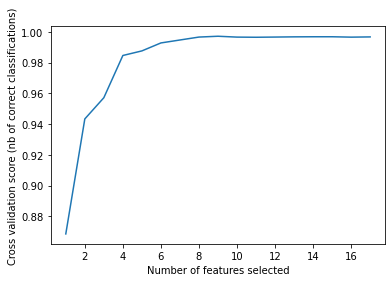

In [25]:
optimal_features(bnb)

In [26]:
X_train_new, X_test_new, y_train, y_test = feat_select_split(17)
run_model(bnb, X_train=X_train_new, X_test=X_test_new)

Number of mislabeled points out of a total 6419 points : 54
Accuracy:  0.9915874746845303
Recall:  0.34285714285714286
Precision:  0.27906976744186046
F1:  0.3076923076923077
Area Under Curve:  0.6690006265664161
[[6353   31]
 [  23   12]]


CV Training
[0.99824641 0.99918436 0.99977872 0.99960241 0.99964522 0.99975169
 0.99900544 0.99991188 0.99909225 0.99911815]
Average:  0.9993336521484641


CV Test
[0.81455399 0.80751174 0.80933751 0.98174231 0.97727273 0.98373824
 0.98961599 0.83581505 0.57974138 0.79022989]
Average:  0.8569558810543512


Looks exactly the same as above.  Having no parameters is perhaps the reason.

---
## KNN

In [20]:
neighbors = KNeighborsClassifier()
run_model(neighbors)

Number of mislabeled points out of a total 6419 points : 733
Accuracy:  0.8858077582177909
Recall:  0.3142857142857143
Precision:  0.015277777777777777
F1:  0.02913907284768212
Area Under Curve:  0.6016134085213033
[[5675  709]
 [  24   11]]


CV Training
[0.87103349 0.86006387 0.92591154 0.94801533 0.91741663 0.89521733
 0.86820846 0.9227188  0.89386723 0.90585633]
Average:  0.9008308998765964


CV Test
[0.49530516 0.49217527 0.4827856  0.48669797 0.61539969 0.48902821
 0.48824451 0.61559561 0.49137931 0.48432602]
Average:  0.5140937360491755


There is a bit of overfitting (90% to 51%)

---
## Random Forest

In [22]:
rfc = RandomForestClassifier()
run_model(rfc)

Number of mislabeled points out of a total 6419 points : 45
Accuracy:  0.9929895622371085
Recall:  0.3142857142857143
Precision:  0.34375
F1:  0.3283582089552239
Area Under Curve:  0.6554981203007519
[[6363   21]
 [  24   11]]


CV Training
[0.99904565 0.99920673 0.99985761 0.99965625 0.99961068 0.99978209
 0.99887081 0.99995655 0.99936648 0.99946172]
Average:  0.9994814587381748


CV Test
[0.80907668 0.80646844 0.80777256 0.98904538 0.85423197 0.83326803
 0.99196708 0.81720219 0.58052508 0.77821317]
Average:  0.8267770590803616


Optimal number of features : 9


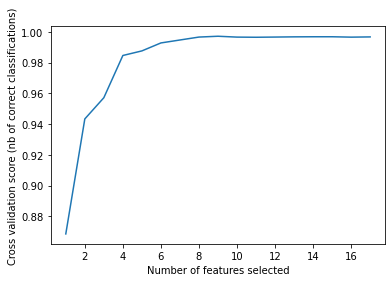

In [25]:
optimal_features(rfc)

In [26]:
X_train_new, X_test_new, y_train, y_test = feat_select_split(9)
run_model(rfc, X_train=X_train_new, X_test=X_test_new)

Number of mislabeled points out of a total 6419 points : 54
Accuracy:  0.9915874746845303
Recall:  0.34285714285714286
Precision:  0.27906976744186046
F1:  0.3076923076923077
Area Under Curve:  0.6690006265664161
[[6353   31]
 [  23   12]]


CV Training
[0.99824641 0.99918436 0.99977872 0.99960241 0.99964522 0.99975169
 0.99900544 0.99991188 0.99909225 0.99911815]
Average:  0.9993336521484641


CV Test
[0.81455399 0.80751174 0.80933751 0.98174231 0.97727273 0.98373824
 0.98961599 0.83581505 0.57974138 0.79022989]
Average:  0.8569558810543512


99.9% training to 85.7% test: a bit of overfitting.

---
## Support Vector

In [23]:
svc = SVC()
run_model(svc)

Number of mislabeled points out of a total 6419 points : 2186
Accuracy:  0.6594485122293192
Recall:  0.4857142857142857
Precision:  0.007780320366132723
F1:  0.015315315315315315
Area Under Curve:  0.5730576441102757
[[4216 2168]
 [  18   17]]


CV Training
[0.7915962  0.6737679  0.72640912 0.6823869  0.758735   0.54661727
 0.64326605 0.67186384 0.64824531 0.58392655]
Average:  0.6726814127368348


CV Test
[0.50391236 0.35054773 0.4428795  0.32968179 0.24490596 0.69592476
 0.5380094  0.56935737 0.5854232  0.28369906]
Average:  0.45443411368010683


Default results do not look promising.  And with each test taking 5x longer than other models, I will choose to leave this model as is.

---
## Gradient Boosting

In [24]:
clf = GradientBoostingClassifier()
run_model(clf)

Number of mislabeled points out of a total 6419 points : 115
Accuracy:  0.9820844368281664
Recall:  0.5142857142857142
Precision:  0.15517241379310345
F1:  0.2384105960264901
Area Under Curve:  0.7494674185463659
[[6286   98]
 [  17   18]]


CV Training
[0.98300175 0.98548212 0.98971848 0.99334921 0.98809501 0.98304241
 0.98744489 0.98867369 0.9882433  0.97803866]
Average:  0.98650895117444


CV Test
[0.68675013 0.63432447 0.76499739 0.92905582 0.89968652 0.66555643
 0.84463166 0.67692006 0.47511755 0.44278997]
Average:  0.7019829998217565


Optimal number of features : 17


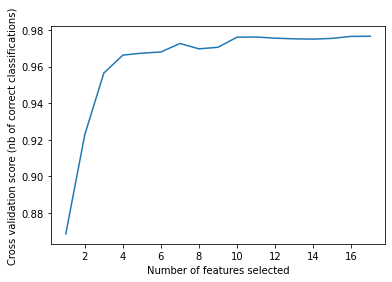

In [27]:
optimal_features(clf)

In [29]:
X_train_new, X_test_new, y_train, y_test = feat_select_split(17)
run_model(clf, X_train=X_train_new, X_test=X_test_new)

Number of mislabeled points out of a total 6419 points : 116
Accuracy:  0.9819286493223244
Recall:  0.5142857142857142
Precision:  0.15384615384615385
F1:  0.2368421052631579
Area Under Curve:  0.7493890977443608
[[6285   99]
 [  17   18]]


CV Training
[0.9858667  0.98381087 0.98724943 0.99350569 0.98666916 0.98700854
 0.98597051 0.99151632 0.98427745 0.98246563]
Average:  0.9868340292002082


CV Test
[0.69196661 0.63432447 0.76499739 0.92957746 0.89968652 0.66555643
 0.84463166 0.67731191 0.47511755 0.44278997]
Average:  0.7025959980246042


98.7% training to 70.3% test: a bit more overfitting than Random Forest.

# Tentatively Winning Model
The default `Naive Bayes`, `Random Forest`, and `Gradient Boosting` all show promising results.

For no particular reason, we'll focus on `Gradient Boosting` and use `GridSearchCV` to locate optimal parameters for for the model.

In [38]:
gbc = GradientBoostingClassifier()
parameters = {
    'n_estimators':[5,50,250,500],
    'max_depth':[1,3,5,7,9],
    'learning_rate':[0.01, 0.1, 1, 10, 100]
}

The following takes hours to run.  The final results just in case I accidently delete them.
```
Best parameters are: 
    {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
```

In [39]:
cv = GridSearchCV(gbc, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]})

In [40]:
# cv.best_params_
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [41]:
display(cv)

Best parameters are: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}


0.865 + or -0.021 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.865 + or -0.021 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.868 + or -0.022 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.881 + or -0.025 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.885 + or -0.026 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.891 + or -0.021 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.893 + or -0.022 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.902 + or -0.022 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.896 + or -0.019 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.9 + or -0.02 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.91 + or -0.022 for the {'learning_rate': 0.01, 'max_depth

Plugging in optimal parameters and get slight improvements.

Old: Training: 98.7% Test: 70.3%

New: Training: 99.9% Test: 78.4%

In [42]:
clf_2 = GradientBoostingClassifier(learning_rate=0.1, 
                                  n_estimators=500, 
                                  max_depth=7)
run_model(clf_2)

Number of mislabeled points out of a total 6419 points : 35
Accuracy:  0.9945474372955289
Recall:  0.37142857142857144
Precision:  0.5
F1:  0.42622950819672134
Area Under Curve:  0.6846961152882206
[[6371   13]
 [  22   13]]


CV Training
[0.99917755 0.99914844 0.99979151 0.99985539 0.99982276 0.99996492
 0.99954486 0.99995433 0.99980032 0.9997381 ]
Average:  0.9996798194353749


CV Test
[0.6885759  0.85811163 0.79081899 0.66770996 0.89537618 0.80799373
 0.98471787 0.64224138 0.75920846 0.74660397]
Average:  0.7841358072386484


Optimal number of features : 12


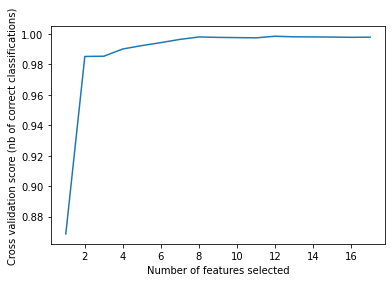

In [43]:
optimal_features(clf_2)

Optimal features for this model is 12 features.  Will run model again with top-12 features and see minimal performance hit, if any.

In [46]:
X_train_new, X_test_new, y_train, y_test = feat_select_split(12)
run_model(clf_2, X_train=X_train_new, X_test=X_test_new)

Number of mislabeled points out of a total 6419 points : 34
Accuracy:  0.994703224801371
Recall:  0.4
Precision:  0.5185185185185185
F1:  0.45161290322580644
Area Under Curve:  0.6989818295739347
[[6371   13]
 [  21   14]]


CV Training
[0.99557309 0.99936137 0.99978707 0.99976026 0.99979596 0.99983762
 0.99957352 0.99995142 0.99978454 0.99965964]
Average:  0.9993084486314322


CV Test
[0.70448618 0.7209181  0.95722483 0.7219614  0.98589342 0.88636364
 0.90517241 0.53565831 0.74353448 0.72753396]
Average:  0.7888746723344828


## Test Set:

### 2nd Quarter 2018 Data

Running the 2nd-quarter data through Gradient Boosting model:

In [47]:
df2 = pd.read_csv('2nd_quarter_ldw_df.csv')

cols_to_keep = [col for col in df2.columns if 'smart' in col]
# Splitting into Features and Labels
features = df2[cols_to_keep]
labels = df2['failure']

In [53]:
# New model only accepts the 12-best features
# Using feature selection SelectKBest to select the 12 most-important features
features_new = SelectKBest(chi2, k=12).fit_transform(features, labels)
y_pred = clf_2.predict(features_new)

In [54]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    features_new.shape[0],
    (labels != y_pred).sum()
))
get_metrics(y_pred, labels)

Number of mislabeled points out of a total 32091 points : 34
Accuracy:  0.998940512916394
Recall:  0.8806818181818182
Precision:  0.9226190476190477
F1:  0.9011627906976746
Area Under Curve:  0.9401372431031291
[[31902    13]
 [   21   155]]


# Conclusion

We've managed to crate a model using Gradient Boosting that is 99.89% accurate.

- Out of 32,091 HD’s, we mislabeled 34 (99.89% accuracy)
- **Recall**: 88% (caught 88% of actual HD failures)
    - We successfully caught **155** failing HDs (higher the better)
    - We failed to catch **21** failing HDs (lower the better)
- **Precision**: 92% (When we threw HDs out, we were 92% correct)
    - We discard **168** HDs
    - **13** of them were not failing (lower the better)